## Setup

In [ ]:
import os

In [ ]:
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False
print(IN_COLAB)

True


In [ ]:
!pip install graph_nets  dm-sonnet tensorflow_probability

In [ ]:
if IN_COLAB and 'drive' not in os.listdir("/content"):
    from google.colab import drive

    drive.mount('/content/drive')

In [ ]:
if IN_COLAB:
    os.chdir('/content/drive/MyDrive/bakalarka')

In [ ]:
import tensorflow as tf

import time
import sys
import re

from graph_nets import utils_tf


In [ ]:
from EncodeProcessDecodeBasic import EncodeProcessDecode
from EncodeProcessDecodeNorm import EncodeProcessDecode as EncodeProcessDecodeNorm
from EncodeProcessDecodeAddNorm import EncodeProcessDecode as EncodeProcessDecodeAddNorm
from EncodeProcessDecodeNoLib import EncodeProcessDecode as EncodeProcessDecodeNoLib
from EncodeProcessDecodeMultinet import EncodeProcessDecode as EncodeProcessDecodeMultinet
from EncodeProcessDecodeNamedMultinet import EncodeProcessDecode as EncodeProcessDecodeNamedMultinet

In [ ]:
mod = "named"
models = {"named": {"model": EncodeProcessDecodeNamedMultinet,
                    "args": {"steps": 15,
                             "learn_features": 2,
                             "n_layers": 2,
                             "lat_size": 128,
                             "edge_feat_cnt": 3,
                             "node_feat_cnt": 5},
                    "params": [dict(noise=0.02, gamma=1.0, field='velocity', history=False,
                                    size=2, batch=2)],
                    "path": "namednet"},
          "named18": {"model": EncodeProcessDecodeNamedMultinet,
                      "args": {"steps": 18,
                               "learn_features": 2,
                               "n_layers": 2,
                               "lat_size": 128,
                               "edge_feat_cnt": 3,
                               "node_feat_cnt": 5},
                      "params": [dict(noise=0.02, gamma=1.0, field='velocity', history=False,
                                      size=2, batch=2)],
                      "path": "namednet18"},
          "named12": {"model": EncodeProcessDecodeNamedMultinet,
                      "args": {"steps": 12,
                               "learn_features": 2,
                               "n_layers": 2,
                               "lat_size": 128,
                               "edge_feat_cnt": 3,
                               "node_feat_cnt": 5},
                      "params": [dict(noise=0.02, gamma=1.0, field='velocity', history=False,
                                      size=2, batch=2)],
                      "path": "namednet12"
                      },
          "named-full": {"model": EncodeProcessDecodeNamedMultinet,
                         "args": {"steps": 12,
                                  "learn_features": 4,
                                  "n_layers": 2,
                                  "lat_size": 128,
                                  "edge_feat_cnt": 3,
                                  "node_feat_cnt": 7},
                         "params": [dict(noise=0.02, gamma=1.0, field='velocity', history=False,
                                         size=2, batch=2),
                                    dict(noise=0.02, gamma=1.0, field='pressure', history=False,
                                         size=1, batch=2),
                                    dict(noise=0.02, gamma=1.0, field='density', history=False,
                                         size=1, batch=2)],
                         "path": "fullnet"},
          "named12n": {"model": EncodeProcessDecodeNamedMultinet,
                    "args": {"steps": 12,
                             "learn_features": 2,
                             "n_layers": 2,
                             "lat_size": 128,
                             "edge_feat_cnt": 3,
                             "node_feat_cnt": 5},
                    "params": [dict(noise=1.0, gamma=1.0, field='velocity', history=False,
                                    size=2, batch=2)]},
                    "path": "namednet12n"}

In [ ]:
params = models[mod]["params"]
targets = tuple([x["field"] for x in params])

In [ ]:
from common import NodeType

## Data Loading

In [ ]:
data_path = 'data/airfoil'
data_train = 'small' if IN_COLAB else 'train'
data_valid = 'small' if IN_COLAB else 'valid'
data_test = 'small' if IN_COLAB else 'test'

In [ ]:
from dataset import load_dataset, split_dataset, prepare, add_noises, add_targets, add_batch, triangles_to_edges

In [ ]:
ds = load_dataset(data_path, data_train)
ds = add_targets(ds, targets, add_history=params[0]['history'])

In [ ]:
ds = split_dataset(ds)
for param in params:
    ds = add_noises(ds, noise_field=param['field'],
                    noise_scale=param['noise'],
                    noise_gamma=param['gamma'])
ds = prepare(ds, 100 if IN_COLAB else 10000)

In [ ]:
ds = add_batch(ds, params[0]['batch'])

## Prepare for learning

In [ ]:
itr = iter(ds)
d = itr.next()

In [ ]:
NodeTypeCnt = tf.unique(tf.reshape(d['node_type'], d['node_type'].shape[:1])).y.shape[0]

In [ ]:
@tf.function
def toGraphsTuple(d, targets=('velocity',)):
    send, recive = triangles_to_edges(d['cells'])
    rel_pos = (tf.gather(d['mesh_pos'], send) - tf.gather(d['mesh_pos'], recive))
    nodes_unique = tf.unique_with_counts(tf.reshape(d["node_type"], [-1]))
    one_hot = tf.one_hot(nodes_unique.idx, NodeTypeCnt, dtype=tf.float32)
    dd = {
        "nodes": tf.concat([*[d[x] for x in targets], one_hot], 1),
        # on change update loss function ^
        "senders": send,
        "receivers": recive,
        "edges": tf.concat([
            rel_pos,
            tf.norm(rel_pos, axis=-1, keepdims=True)], 1)
    }
    return utils_tf.data_dicts_to_graphs_tuple([dd])

In [ ]:
dd = toGraphsTuple(d, targets)
LINEAR_FEATURES = dd.nodes.shape[1] - NodeTypeCnt

In [ ]:
dd

GraphsTuple(nodes=<tf.Tensor: shape=(10466, 5), dtype=float32, numpy=
array([[247.22981 ,  31.880196,   1.      ,   0.      ,   0.      ],
       [246.06851 ,  35.51987 ,   1.      ,   0.      ,   0.      ],
       [252.82814 ,  36.48702 ,   1.      ,   0.      ,   0.      ],
       ...,
       [257.07364 ,  74.75203 ,   0.      ,   0.      ,   1.      ],
       [257.0814  ,  74.76477 ,   0.      ,   0.      ,   1.      ],
       [257.08984 ,  74.76909 ,   0.      ,   0.      ,   1.      ]],
      dtype=float32)>, edges=<tf.Tensor: shape=(61796, 3), dtype=float32, numpy=
array([[ 0.00579996, -0.01206488,  0.01338659],
       [-0.00720367, -0.01440071,  0.01610196],
       [-0.00630522,  0.0145334 ,  0.0158422 ],
       ...,
       [ 0.30951977,  1.4802246 ,  1.5122392 ],
       [ 1.0828505 ,  1.8325498 ,  2.1285684 ],
       [-0.43042946,  1.2830333 ,  1.3533084 ]], dtype=float32)>, receivers=<tf.Tensor: shape=(61796,), dtype=int32, numpy=array([   69,    55,   159, ..., 10294, 10339, 

In [ ]:
aa = itr.next()

## Model and loss function

### Model hyperparameters

In [ ]:
from AdamModLr import Adam

lr = 1e-4
# opt = snt.optimizers.Adam(lr)
opt = Adam(lr)
steps = 15
#model = EncodeProcessDecode(steps, LINEAR_FEATURES, [128] * 2, [128] * 2 + [4])
md = models[mod]
model = md["model"](**md["args"])
initial_learning_rate = lr
decay_rate = 0.1
decay_steps = 5e6
learning_increase = 1e-6

## Training

In [ ]:
def decayed_learning_rate(step):
    return initial_learning_rate * decay_rate ** (step / decay_steps) + learning_increase

In [ ]:
@tf.function
def update_step(data, targets=('velocity')):
    print("Tracing!")
    grp = toGraphsTuple(data, targets)
    with tf.GradientTape() as tape:
        los = model.loss(grp, data, targets=targets)  #change to loss

    gradients = tape.gradient(los, model.trainable_variables)

    opt.apply(gradients, model.trainable_variables)
    return los

In [ ]:
update_step(aa, targets);

Tracing!
Tracing!


In [ ]:
chck_root = "models/namednet/"
chck_name = mod

chck = tf.train.Checkpoint(module=model)

latest = tf.train.latest_checkpoint(chck_root)
if latest is not None:
    print("loading", latest)
    chck.restore(latest)

loading models/namednet/named-197


In [ ]:
if latest is None and not isinstance(model, EncodeProcessDecode):
    print("Acumulating")
    for i in range(1000):
        data = itr.next()
        grp = toGraphsTuple(data, targets)
        model.loss(grp, data,targets=targets)

In [ ]:
dt2 = load_dataset(data_path, data_train)
dt2 = add_targets(dt2, targets, add_history=params[0]['history'])
qq = iter(dt2).next()
qqq = {}
for i, j in qq.items():
    qqq[i] = j[0]
grp_ = toGraphsTuple(qqq, targets)

In [ ]:
tf.reduce_min(qqq['density']), tf.reduce_max(qqq['density']),tf.reduce_min(qqq['velocity'][0]), tf.reduce_max(qqq['velocity'][0]),tf.reduce_min(qqq['pressure']), tf.reduce_max(qqq['pressure'])

(<tf.Tensor: shape=(), dtype=float32, numpy=0.91523933>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.6733382>,
 <tf.Tensor: shape=(), dtype=float32, numpy=44.354774>,
 <tf.Tensor: shape=(), dtype=float32, numpy=334.88293>,
 <tf.Tensor: shape=(), dtype=float32, numpy=68885.2>,
 <tf.Tensor: shape=(), dtype=float32, numpy=158172.36>)

In [ ]:
if "m" in locals():
    m.numpy()

## Vizualization

In [ ]:
res = [grp_, ]
loss_mask = tf.logical_or(tf.equal(qqq['node_type'][:, 0], NodeType.NORMAL),
                          tf.equal(qqq['node_type'][:, 0], NodeType.OUTFLOW))
feat = grp_.nodes.shape
loss_mask = tf.reshape(tf.concat([loss_mask for _ in range(grp_.nodes.shape[1])], -1), [-1, grp_.nodes.shape[1]])
for i in range(600):
    grp2_ = model(grp_, False)
    grp_ = grp_.replace(nodes=tf.where(loss_mask, grp2_.nodes, grp_.nodes))
    res.append(grp_)

In [ ]:
@tf.function
def toGraphsTupleOld(d):
    send, recive = triangles_to_edges(d['cells'])
    rel_pos = (tf.gather(d['mesh_pos'], send) - tf.gather(d['mesh_pos'], recive))
    nodes_unique = tf.unique_with_counts(tf.reshape(d["node_type"], [-1]))
    dd = {
        #"nodes": tf.concat([d["velocity"],d["pressure"],d["density"],tf.cast(d["node_type"],tf.float32),d["mesh_pos"]],1),
        "nodes": tf.concat([d['velocity'], tf.one_hot(tf.reshape(d["node_type"], [-1]), NodeTypeCnt, dtype=tf.float32)],
                           1),  # on change update loss function ^
        "senders": send,
        "receivers": recive,
        "edges": tf.concat([
            rel_pos,
            tf.norm(rel_pos, axis=-1, keepdims=True)], 1)
    }
    return utils_tf.data_dicts_to_graphs_tuple([dd])

In [ ]:
# fix mistake in data preparation
if chck_root == "models/new":
    grp_ = toGraphsTupleOld(qqq)

In [ ]:
grp_.nodes.shape[1]

5

In [ ]:
res = [grp_, ]
loss_mask = tf.logical_or(tf.equal(qqq['node_type'][:, 0], NodeType.NORMAL),
                          tf.equal(qqq['node_type'][:, 0], NodeType.OUTFLOW))
loss_mask = tf.reshape(tf.concat([loss_mask for _ in range(grp_.nodes.shape[1])], -1), [-1, grp_.nodes.shape[1]])
for i in range(600):
    grp2_ = model(grp_, False)
    grp_ = grp_.replace(nodes=tf.where(loss_mask, grp2_.nodes, grp_.nodes))
    res.append(grp_)

In [ ]:
grp_.nodes.shape, grp2_.nodes.shape, loss_mask.shape

(TensorShape([5233, 5]), TensorShape([5233, 5]), TensorShape([5233, 5]))

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import tri as mtri

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
skip = 5
num_steps = len(res)
num_frames = num_steps // skip
# compute bounds
bounds = []
bb_min, bb_max = tf.reduce_min(qq['velocity'][:, 0]), tf.reduce_max(qq['velocity'][:, 0])


def animate(num):
    global t
    step = (num * skip) % num_steps
    traj = (num * skip) // num_steps
    ax.cla()
    ax.set_xlim(-1, 2)
    ax.set_ylim(-1.5, 1.5)
    ax.set_autoscale_on(False)
    vmin, vmax = bb_min, bb_max
    pos = qqq['mesh_pos']
    faces = qqq['cells']
    velocity = res[step].nodes[..., :2].numpy()
    triang = mtri.Triangulation(pos[:, 0], pos[:, 1], faces)
    t = ax.tripcolor(triang, velocity[:, 0], vmin=vmin, vmax=vmax)
    ax.triplot(triang, 'ko-', ms=0.5, lw=0.3)
    ax.set_title('Trajectory %d Step %d' % (traj, step))
    return fig,


animate(0)
plt.colorbar(t)

anim = FuncAnimation(fig, animate, frames=num_frames, interval=200)
from IPython.display import HTML

HTML(anim.to_html5_video())

Output hidden; open in https://colab.research.google.com to view.

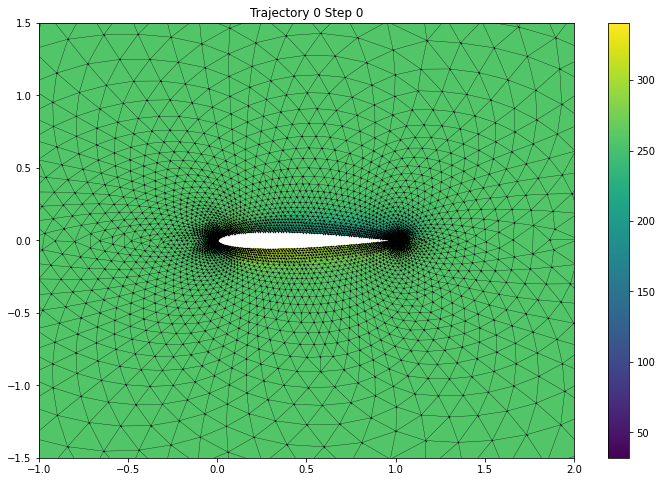

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
skip = 5
num_steps = len(res)
num_frames = num_steps // skip
# compute bounds
bounds = []

bb_min, bb_max = tf.reduce_min(qq['velocity'][:, 0]), tf.reduce_max(qq['velocity'][:, 0])


def animate(num):
    global t
    step = (num * skip) % num_steps
    traj = (num * skip) // num_steps
    ax.cla()
    ax.set_xlim(-1, 2)
    ax.set_ylim(-1.5, 1.5)
    ax.set_autoscale_on(False)
    vmin, vmax = bb_min, bb_max
    pos = qq['mesh_pos'][0]
    faces = qq['cells'][0]
    velocity = qq['velocity'][step]
    triang = mtri.Triangulation(pos[:, 0], pos[:, 1], faces)
    t = ax.tripcolor(triang, velocity[:, 0], vmin=vmin, vmax=vmax)
    ax.triplot(triang, 'ko-', ms=0.5, lw=0.3)
    ax.set_title('Trajectory %d Step %d' % (traj, step))
    return fig,


animate(0)
plt.colorbar(t)

anim = FuncAnimation(fig, animate, frames=num_frames, interval=200)
from IPython.display import HTML

HTML(anim.to_html5_video())

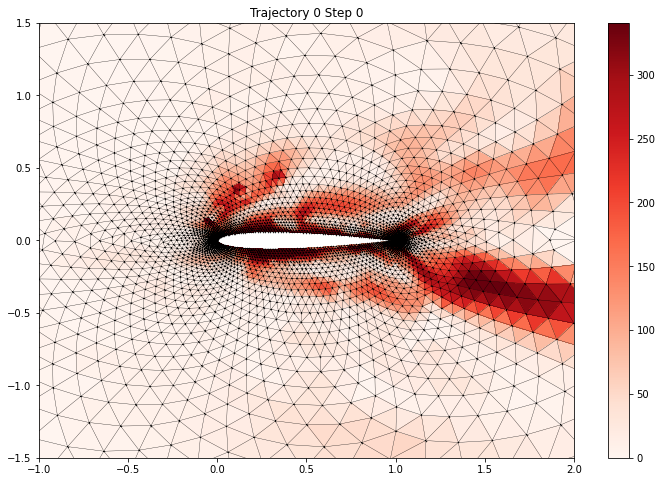

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
skip = 5
num_steps = len(res)
num_frames = num_steps // skip
# compute bounds
bounds = []

bb_min, bb_max = 0, tf.reduce_max(qq['velocity'][:, 0])


def animate(num):
    global t
    step = (num * skip) % num_steps
    traj = (num * skip) // num_steps
    ax.cla()
    ax.set_xlim(-1, 2)
    ax.set_ylim(-1.5, 1.5)
    ax.set_autoscale_on(False)
    vmin, vmax = bb_min, bb_max
    pos = qq['mesh_pos'][0]
    faces = qq['cells'][0]
    velocity = tf.math.abs(qq['velocity'][step] - res[step].nodes[..., :2])
    triang = mtri.Triangulation(pos[:, 0], pos[:, 1], faces)
    t = ax.tripcolor(triang, velocity[:, 0], vmin=vmin, vmax=vmax, cmap='Reds')
    ax.triplot(triang, 'ko-', ms=0.5, lw=0.3)
    ax.set_title('Trajectory %d Step %d' % (traj, step))
    return fig,


animate(0)
plt.colorbar(t)

anim = FuncAnimation(fig, animate, frames=num_frames, interval=200)
from IPython.display import HTML

HTML(anim.to_html5_video())

In [ ]:
bb_min, bb_max

(0, <tf.Tensor: shape=(), dtype=float32, numpy=340.60352>)

In [ ]:
model._node_norm._std_with_epsilon(), model._node_norm._mean()

(<tf.Tensor: shape=(5,), dtype=float32, numpy=
 array([76.54857   , 53.572285  ,  0.19159228,  0.09721107,  0.2019654 ],
       dtype=float32)>, <tf.Tensor: shape=(5,), dtype=float32, numpy=
 array([ 1.6297943e+02, -8.9823055e-01,  3.8164102e-02,  9.5410254e-03,
         9.5739484e-01], dtype=float32)>)

In [ ]:
qq['target|velocity'].shape, qq['velocity'].shape

(TensorShape([599, 5233, 2]), TensorShape([599, 5233, 2]))

In [ ]:
r = tf.reduce_sum((qq['velocity'] - qq['target|velocity']) ** 2)
r

<tf.Tensor: shape=(), dtype=float32, numpy=6338295.5>

In [ ]:
tt = [{i: qq[i][x] for i in qq.keys()} for x in range(599)]

In [ ]:
lss = []
for i in tt:
    lss.append(model.loss(toGraphsTuple(i), i))

In [ ]:
lss = [x.numpy() for x in lss]

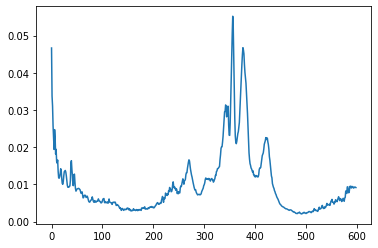

In [ ]:
plt.plot(lss)

In [ ]:
1e7 / (1000 * 600)

16.666666666666668

In [ ]:
ee = [x.shape.as_list() for x in model.trainable_variables]
sum([(y[0] if len(y) == 1 else y[0] * y[1]) for y in ee])

2332162